---
# Predictive Modeling 
# Author: Adefemi Abimbola
---


In [121]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor


In [79]:
#path to each cleaned data set unique to your system
review_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/reviews.csv'
business_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/business.csv'
user_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/user.csv'
checkin_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/checkin.csv'
tip_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/tip.csv'

In [80]:
# read the data
review = pd.read_csv(review_path)
business = pd.read_csv(business_path)
user = pd.read_csv(user_path)
checkin = pd.read_csv(checkin_path)
tip = pd.read_csv(tip_path)

In [81]:
# get the shape of each dataset
print("Review shape:", review.shape)
print("Business shape:", business.shape)
print("User shape:", user.shape)
print("Checkin shape:", checkin.shape)
print("Tip shape:", tip.shape)

Review shape: (1987897, 9)
Business shape: (150346, 12)
User shape: (1987897, 7)
Checkin shape: (131930, 2)
Tip shape: (908915, 5)


---
- Baseline Models(linear Regression & Decision tree)
    - Goal: Predicting business star rating using simple features
---

In [83]:
def extract_attribute(attr_str, key):
    try:
        attr_dict = ast.literal_eval(attr_str)
        return attr_dict.get(key, None)
    except:
        return None


In [84]:
def extract_parking_type(attr_str, parking_type):
    try:
        attr_dict = ast.literal_eval(attr_str)
        parking_str = attr_dict.get('BusinessParking')
        parking_dict = ast.literal_eval(parking_str) if parking_str else {}
        return parking_dict.get(parking_type, None)
    except:
        return None

In [87]:
def simplify_category(cat_string):
    if not isinstance(cat_string, str):
        return 'Other'
    
    cat_string = cat_string.lower()

    if 'restaurant' in cat_string or 'food' in cat_string:
        return 'Restaurant'
    elif 'shopping' in cat_string or 'store' in cat_string:
        return 'Retail'
    elif 'health' in cat_string or 'medical' in cat_string or 'nutritionist' in cat_string:
        return 'Health'
    elif 'beauty' in cat_string or 'spa' in cat_string or 'salon' in cat_string:
        return 'Beauty'
    elif 'bar' in cat_string or 'nightlife' in cat_string or 'club' in cat_string:
        return 'Nightlife'
    elif 'education' in cat_string or 'school' in cat_string:
        return 'Education'
    elif 'service' in cat_string or 'notary' in cat_string:
        return 'Professional Services'
    elif 'public service' in cat_string or 'government' in cat_string:
        return 'Government'
    elif 'automotive' in cat_string or 'car' in cat_string or 'mechanic' in cat_string or 'tire' in cat_string:
        return 'Automotive'
    elif 'gym' in cat_string or 'fitness' in cat_string or 'yoga' in cat_string or 'active life' in cat_string:
        return 'Fitness'
    elif 'pets' in cat_string or 'animal' in cat_string or 'veterinary' in cat_string:
        return 'Veterinary'
    elif 'hotel' in cat_string or 'lodging' in cat_string or 'travel' in cat_string:
        return 'Travel'
    elif 'church' in cat_string or 'temple' in cat_string or 'synagogue' in cat_string or 'place of worship' in cat_string:
        return 'Religious'
    elif 'movie' in cat_string or 'cinema' in cat_string or 'theater' in cat_string or 'art' in cat_string or 'museum' in cat_string or 'entertainment' in cat_string:
        return 'Entertainment'
    elif 'media' in cat_string or 'news' in cat_string or 'radio' in cat_string or 'television' in cat_string:
        return 'Media/Station'
    else:
        return 'Other'


In [82]:
# aggregate the datasets according to the business_id
review_agg = review.groupby('business_id').agg({
    'stars': 'mean',
    'text': lambda x: x.str.len().mean(),  # average length
    'review_id': 'count'  # number of reviews
}).rename(columns={'stars': 'avg_review_rating', 'text': 'avg_review_length', 'review_id': 'num_reviews'})


In [85]:
business = business[['business_id', 'name', 'stars', 'review_count', 'categories', 'attributes', 'is_open']]

business['WiFi'] = business['attributes'].apply(lambda x: extract_attribute(x, 'WiFi'))
business['credit_cards'] = business['attributes'].apply(lambda x: extract_attribute(x, 'BusinessAcceptsCreditCards'))
business['bike_parking'] = business['attributes'].apply(lambda x: extract_attribute(x, 'BikeParking'))
business['parking_garage'] = business['attributes'].apply(lambda x: extract_parking_type(x, 'garage'))
business['parking_lot'] = business['attributes'].apply(lambda x: extract_parking_type(x, 'lot'))
business['parking_street'] = business['attributes'].apply(lambda x: extract_parking_type(x, 'street'))

# Encode WiFi
business['WiFi'] = business['WiFi'].map({'free': 2, 'paid': 1, 'no': 0, 'None': 0})


In [86]:
# merge the business and review dataframes
baseline_df = business.merge(review_agg, on='business_id', how='left')

# cleaning the baseline_df
baseline_df = baseline_df.dropna(subset=['avg_review_rating', 'avg_review_length', 'num_reviews'])

# simplifying the categories
baseline_df['category_simple'] = baseline_df['categories'].apply(simplify_category)


In [92]:
# Drop columns we won't use
drop_cols = ['business_id', 'name', 'categories', 'attributes']
baseline_df = baseline_df.drop(columns=drop_cols)

# Define X and y
X = baseline_df.drop(columns=['stars'])
y = baseline_df['stars']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Handle missing values and encoding
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])

# Create a pipeline with preprocessing and model
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

print("🔹 Linear Regression Results:")
print("RMSE:", mean_squared_error(y_test, lr_preds, squared=False))
print("R² Score:", r2_score(y_test, lr_preds))

# Decision Tree Regressor
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', DecisionTreeRegressor(random_state=42))])

dt_pipeline.fit(X_train, y_train)
dt_preds = dt_pipeline.predict(X_test)

print("\n🔹 Decision Tree Results:")
print("RMSE:", mean_squared_error(y_test, dt_preds, squared=False))
print("R² Score:", r2_score(y_test, dt_preds))

🔹 Linear Regression Results:
RMSE: 0.24744128366567258
R² Score: 0.9344412253640886


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



🔹 Decision Tree Results:
RMSE: 0.3132824389152651
R² Score: 0.894910673244709


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': 'Linear Regression Predictions vs Actual Ratings'}, xlabel='stars', ylabel='dt'>

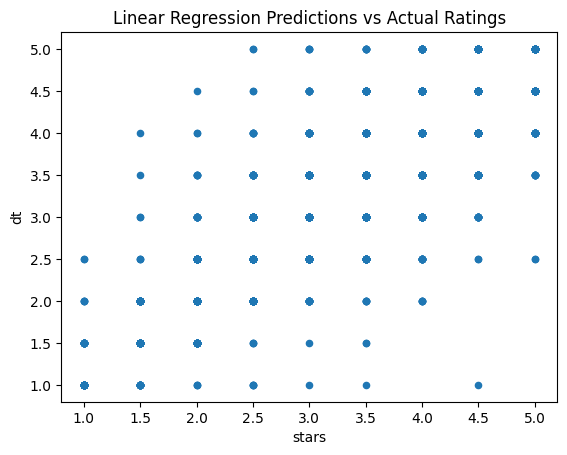

In [113]:
ex = pd.DataFrame(y_test.copy())
ex['lr'] = lr_preds
ex['dt'] = dt_preds
ex['lr'] = round(ex['lr'],1)

ex

# Plotting the results
ex.plot(x='stars', y='dt', kind='scatter', title='Linear Regression Predictions vs Actual Ratings')


In [128]:
ext = ex[ex['stars']==3.0]
ext.describe()

,stars,lr,dt
count,1078.0,1078.000000,1078.000000
mean,3.0,3.052968,3.034323
std,0.0,0.282589,0.358256
min,3.0,1.100000,1.000000
25%,3.0,2.900000,3.000000
50%,3.0,3.000000,3.000000
75%,3.0,3.200000,3.000000
max,3.0,4.900000,5.000000


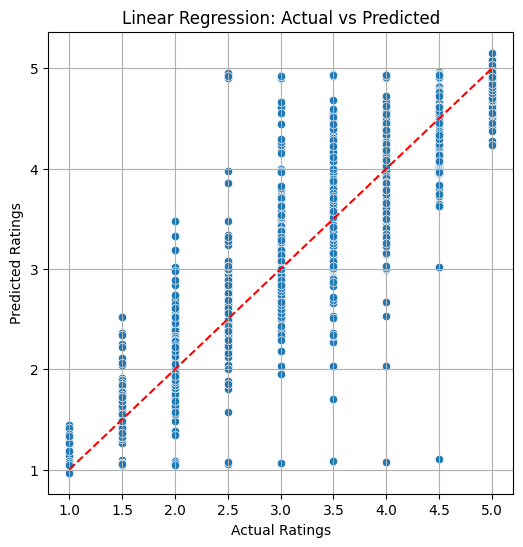

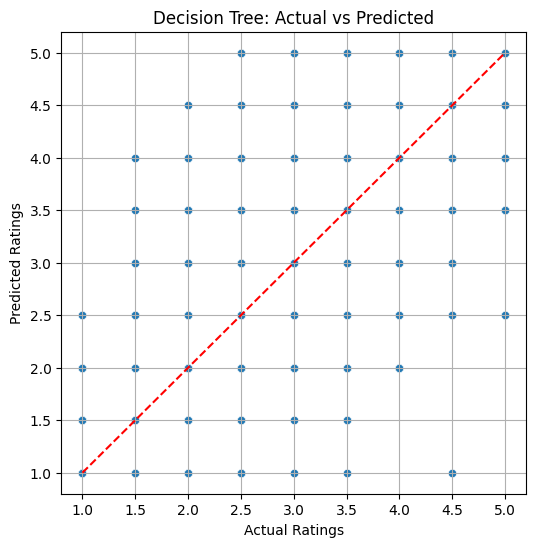

In [110]:
# Plotting function
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title(title)
    plt.grid(True)
    plt.show()

# For Linear Regression
plot_predictions(y_test, lr_preds, "Linear Regression: Actual vs Predicted")

# For Decision Tree
plot_predictions(y_test, dt_preds, "Decision Tree: Actual vs Predicted")


In [130]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)

print("🔹 XGBoost Results:")
print("RMSE:", mean_squared_error(y_test, xgb_preds, squared=False))
print("R² Score:", r2_score(y_test, xgb_preds))



🔹 XGBoost Results:
RMSE: 0.22121820076594303
R² Score: 0.9476003701647432


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': 'XGBoost Predictions vs Actual Ratings'}, xlabel='stars', ylabel='xgb'>

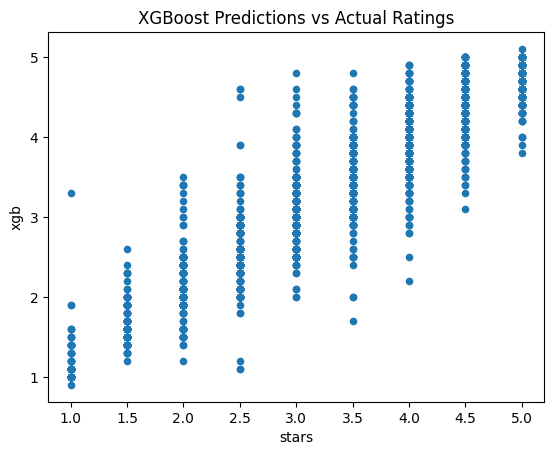

In [134]:
ex['xgb'] = xgb_preds
ex['xgb'] = round(ex['xgb'],1)
ex

ex.plot(x='stars', y='xgb', kind='scatter', title='XGBoost Predictions vs Actual Ratings')